# 🎵 Song Release Year Prediction - Model Training

This notebook trains multiple regression models to predict the year a song was released based on its audio features.

**Dataset Context:** Audio features of songs (timbre, pitch, rhythm, etc.) used to predict release year.

## Models to Train:
1. Linear Regression
2. Ridge Regression
3. Lasso Regression
4. ElasticNet Regression
5. Decision Tree Regressor
6. Random Forest Regressor
7. Gradient Boosting Regressor
8. XGBoost Regressor (if available)
9. Support Vector Regressor (SVR)
10. K-Nearest Neighbors Regressor

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from datetime import datetime

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Try to import XGBoost
try:
    from xgboost import XGBRegressor
    xgboost_available = True
    print("✓ XGBoost is available")
except ImportError:
    xgboost_available = False
    print("⚠ XGBoost not available. Install with: pip install xgboost")

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
print("\n✓ All libraries imported successfully!")

✓ XGBoost is available

✓ All libraries imported successfully!


## Load Processed Data

In [2]:
# Load the scaled dataset (StandardScaler version recommended)
print("Loading processed song features data...\n")

df = pd.read_csv('cars_scaled_standard.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns (audio features): {df.shape[1]}")
print(f"Rows (songs): {df.shape[0]:,}")
print(f"\nFirst few rows:")
df.head()

Loading processed song features data...

Dataset shape: (515130, 100)
Columns (audio features): 100
Rows (songs): 515,130

First few rows:


,2001,49.94357,21.47114,73.0775,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,2.26327,feature_sum,feature_mean,feature_std,feature_min,feature_max,feature_range,num_positive,num_negative,positive_ratio
0,2001,0.897119,0.340776,1.832149,0.772068,-0.169637,-1.232206,0.800067,0.115965,1.505517,...,1.303308,-0.714015,-0.714015,-0.729524,0.377471,-0.422735,-0.437059,0.754446,-0.754444,0.754446
1,2001,1.272365,0.609508,1.401274,0.802770,0.001628,-0.724991,-0.064422,-0.072825,1.235229,...,-0.096608,-1.247273,-1.247273,-1.150659,0.713968,-1.070976,-1.063895,0.295308,-0.295307,0.295308
2,2001,0.815383,-0.066078,0.821536,0.096232,0.346899,-1.343440,0.533412,-1.127676,-0.020300,...,0.893911,-0.842589,-0.842589,-0.708272,1.065736,-0.349783,-0.496472,-0.622966,0.622968,-0.622966
3,2001,1.274568,0.816740,1.736307,0.479876,-0.422435,-0.585022,-0.724961,-1.000306,0.890946,...,1.396102,-1.263565,-1.263565,-1.229833,0.717071,-1.146780,-1.130709,-1.311672,1.311674,-1.311672
4,2001,1.203308,-0.021764,2.486225,1.388011,-0.864429,-0.765311,1.654661,-0.448923,-0.011715,...,-0.061789,-1.188286,-1.188286,-1.168220,0.749370,-1.077859,-1.076247,-0.622966,0.622968,-0.622966


## Prepare Data for Training

In [3]:
# Separate features and target
target_col = df.columns[0]  # First column is the target
X = df.drop(columns=[target_col])
y = df[target_col]

print(f"Target variable: {target_col}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]:,}")
print(f"\nTarget statistics:")
print(y.describe())

Target variable: 2001
Number of features: 99
Number of samples: 515,130

Target statistics:
count    515130.000000
mean       1998.396300
std          10.931639
min        1922.000000
25%        1994.000000
50%        2002.000000
75%        2006.000000
max        2011.000000
Name: 2001, dtype: float64


In [4]:
# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nFeatures: {X_train.shape[1]}")

Training set size: 412,104 samples (80.0%)
Test set size: 103,026 samples (20.0%)

Features: 99


## Define Evaluation Function

In [5]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a regression model.
    
    Returns:
        dict: Dictionary containing evaluation metrics
    """
    print(f"\n{'='*80}")
    print(f"Training: {model_name}")
    print(f"{'='*80}")
    
    # Train the model
    start_time = datetime.now()
    model.fit(X_train, y_train)
    training_time = (datetime.now() - start_time).total_seconds()
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Print results
    print(f"\n📊 Training Metrics:")
    print(f"   RMSE: {train_rmse:.4f}")
    print(f"   MAE:  {train_mae:.4f}")
    print(f"   R²:   {train_r2:.4f}")
    
    print(f"\n📊 Test Metrics:")
    print(f"   RMSE: {test_rmse:.4f}")
    print(f"   MAE:  {test_mae:.4f}")
    print(f"   R²:   {test_r2:.4f}")
    
    print(f"\n⏱️  Training Time: {training_time:.2f} seconds")
    
    # Check for overfitting
    if train_r2 - test_r2 > 0.1:
        print(f"\n⚠️  Warning: Possible overfitting detected (R² difference: {train_r2 - test_r2:.4f})")
    
    return {
        'model_name': model_name,
        'model': model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'training_time': training_time,
        'predictions': y_test_pred
    }

## Train Models

### 1. Linear Regression

In [6]:
# Linear Regression
lr_model = LinearRegression()
lr_results = evaluate_model(lr_model, X_train, X_test, y_train, y_test, "Linear Regression")


Training: Linear Regression

📊 Training Metrics:
   RMSE: 9.4608
   MAE:  6.7373
   R²:   0.2522

📊 Test Metrics:
   RMSE: 9.4113
   MAE:  6.7181
   R²:   0.2538

⏱️  Training Time: 4.17 seconds


### 2. Ridge Regression

In [7]:
# Ridge Regression (L2 regularization)
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_results = evaluate_model(ridge_model, X_train, X_test, y_train, y_test, "Ridge Regression")


Training: Ridge Regression

📊 Training Metrics:
   RMSE: 9.4609
   MAE:  6.7373
   R²:   0.2522

📊 Test Metrics:
   RMSE: 9.4114
   MAE:  6.7181
   R²:   0.2538

⏱️  Training Time: 0.49 seconds


### 3. Lasso Regression

In [8]:
# Lasso Regression (L1 regularization)
lasso_model = Lasso(alpha=0.1, random_state=42, max_iter=10000)
lasso_results = evaluate_model(lasso_model, X_train, X_test, y_train, y_test, "Lasso Regression")


Training: Lasso Regression

📊 Training Metrics:
   RMSE: 9.5266
   MAE:  6.7727
   R²:   0.2418

📊 Test Metrics:
   RMSE: 9.4818
   MAE:  6.7564
   R²:   0.2426

⏱️  Training Time: 5.61 seconds


### 4. ElasticNet Regression

In [9]:
# ElasticNet Regression (L1 + L2 regularization)
elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000)
elasticnet_results = evaluate_model(elasticnet_model, X_train, X_test, y_train, y_test, "ElasticNet Regression")


Training: ElasticNet Regression

📊 Training Metrics:
   RMSE: 9.5229
   MAE:  6.7950
   R²:   0.2424

📊 Test Metrics:
   RMSE: 9.4777
   MAE:  6.7786
   R²:   0.2433

⏱️  Training Time: 5.13 seconds


### 5. Decision Tree Regressor

In [10]:
# Decision Tree Regressor
dt_model = DecisionTreeRegressor(max_depth=10, min_samples_split=20, random_state=42)
dt_results = evaluate_model(dt_model, X_train, X_test, y_train, y_test, "Decision Tree Regressor")


Training: Decision Tree Regressor

📊 Training Metrics:
   RMSE: 9.4046
   MAE:  6.6260
   R²:   0.2611

📊 Test Metrics:
   RMSE: 9.6912
   MAE:  6.8158
   R²:   0.2088

⏱️  Training Time: 57.85 seconds


### 6. Random Forest Regressor

In [11]:
rf_model = RandomForestRegressor(
    n_estimators=300,          # more trees → smoother model
    max_depth=10,              # shallower → less overfitting
    min_samples_split=20,
    min_samples_leaf=5,        # THIS helps a lot with variance
    max_features="sqrt",       # reduce correlation between trees
    random_state=42,
    n_jobs=-1,
    verbose=2
)
rf_results = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest Regressor")


Training: Random Forest Regressor


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 300building tree 2 of 300
building tree 3 of 300

building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.6s


building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300building tree 43 of 300

building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300building tree 58 of 300

building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.2min


building tree 155 of 300
building tree 156 of 300
building tree 157 of 300
building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.3s



📊 Training Metrics:
   RMSE: 9.5431
   MAE:  6.9022
   R²:   0.2392

📊 Test Metrics:
   RMSE: 9.6766
   MAE:  7.0120
   R²:   0.2112

⏱️  Training Time: 257.08 seconds


[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.7s finished


### 7. Gradient Boosting Regressor

In [12]:
# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, 
                                      random_state=42, verbose=1)
gb_results = evaluate_model(gb_model, X_train, X_test, y_train, y_test, "Gradient Boosting Regressor")


Training: Gradient Boosting Regressor
      Iter       Train Loss   Remaining Time 
         1         115.9387           52.00m
         2         112.7713           54.92m
         3         110.1467           53.16m
         4         107.8345           52.03m
         5         105.8781           51.09m
         6         104.1050           50.25m
         7         102.5790           49.72m
         8         101.1755           49.00m
         9          99.9943           48.39m
        10          98.8852           47.81m
        20          92.0295           44.95m


KeyboardInterrupt: 

### 8. XGBoost Regressor (if available)

In [13]:
# XGBoost Regressor
if xgboost_available:
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, 
                             random_state=42, n_jobs=-1, verbosity=2)
    xgb_results = evaluate_model(xgb_model, X_train, X_test, y_train, y_test, "XGBoost Regressor")
else:
    print("\nSkipping XGBoost (not installed)")
    xgb_results = None


Training: XGBoost Regressor
[00:28:28] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (412104, 99, 40798296).
[00:28:28] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (412104, 99, 40798296).

📊 Training Metrics:
   RMSE: 8.9885
   MAE:  6.3064
   R²:   0.3250

📊 Test Metrics:
   RMSE: 9.0538
   MAE:  6.3614
   R²:   0.3095

⏱️  Training Time: 10.15 seconds

📊 Training Metrics:
   RMSE: 8.9885
   MAE:  6.3064
   R²:   0.3250

📊 Test Metrics:
   RMSE: 9.0538
   MAE:  6.3614
   R²:   0.3095

⏱️  Training Time: 10.15 seconds


### 9. Support Vector Regressor (SVR)

In [ ]:
# Support Vector Regressor (using subset for faster training)
print("\n⚠️  Note: Training SVR on a subset (50,000 samples) due to computational cost...")

# Use subset for SVR
subset_size = min(50000, len(X_train))
X_train_subset = X_train.iloc[:subset_size]
y_train_subset = y_train.iloc[:subset_size]

svr_model = SVR(kernel='rbf', C=10, gamma='scale', verbose=True)
svr_results = evaluate_model(svr_model, X_train_subset, X_test, y_train_subset, y_test, 
                             "Support Vector Regressor (SVR)")

### 10. K-Nearest Neighbors Regressor

In [14]:
# K-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
knn_results = evaluate_model(knn_model, X_train, X_test, y_train, y_test, "K-Nearest Neighbors Regressor")


Training: K-Nearest Neighbors Regressor


KeyboardInterrupt: 

## Collect All Results

In [16]:
# Collect all results (only those that were actually trained)
all_results = []

# Check each model result and only add if it exists
model_results_to_check = [
    ('lr_results', 'lr_results'),
    ('ridge_results', 'ridge_results'),
    ('lasso_results', 'lasso_results'),
    ('elasticnet_results', 'elasticnet_results'),
    ('dt_results', 'dt_results'),
    ('rf_results', 'rf_results'),
    ('gb_results', 'gb_results'),
    ('xgb_results', 'xgb_results'),
    ('svr_results', 'svr_results'),
    ('knn_results', 'knn_results')
]

for var_name, result_name in model_results_to_check:
    try:
        result = eval(result_name)
        if result is not None:
            all_results.append(result)
            print(f"✓ Added {result['model_name']} to comparison")
    except NameError:
        print(f"⊘ Skipped {var_name} (not trained yet)")

print(f"\n📊 Total models to compare: {len(all_results)}")

# Create comparison DataFrame
results_df = pd.DataFrame([{
    'Model': r['model_name'],
    'Train RMSE': r['train_rmse'],
    'Test RMSE': r['test_rmse'],
    'Train MAE': r['train_mae'],
    'Test MAE': r['test_mae'],
    'Train R²': r['train_r2'],
    'Test R²': r['test_r2'],
    'Training Time (s)': r['training_time']
} for r in all_results])

# Sort by Test R² (descending)
results_df = results_df.sort_values('Test R²', ascending=False)

print("\n" + "="*100)
print("MODEL COMPARISON SUMMARY")
print("="*100)
print(results_df.to_string(index=False))

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_test_r2 = results_df.iloc[0]['Test R²']
print(f"\n🏆 Best Model: {best_model_name} (Test R² = {best_test_r2:.4f})")

✓ Added Linear Regression to comparison
✓ Added Ridge Regression to comparison
✓ Added Lasso Regression to comparison
✓ Added ElasticNet Regression to comparison
✓ Added Decision Tree Regressor to comparison
✓ Added Random Forest Regressor to comparison
⊘ Skipped gb_results (not trained yet)
✓ Added XGBoost Regressor to comparison
⊘ Skipped svr_results (not trained yet)
⊘ Skipped knn_results (not trained yet)

📊 Total models to compare: 7

MODEL COMPARISON SUMMARY
                  Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  Test R²  Training Time (s)
      XGBoost Regressor    8.988490   9.053785   6.306449  6.361446  0.325031 0.309467          10.153363
      Linear Regression    9.460849   9.411349   6.737254  6.718113  0.252226 0.253848           4.174762
       Ridge Regression    9.460853   9.411367   6.737253  6.718140  0.252225 0.253845           0.490946
  ElasticNet Regression    9.522892   9.477687   6.795024  6.778634  0.242386 0.243292           5.125316
 

## Visualize Model Performance

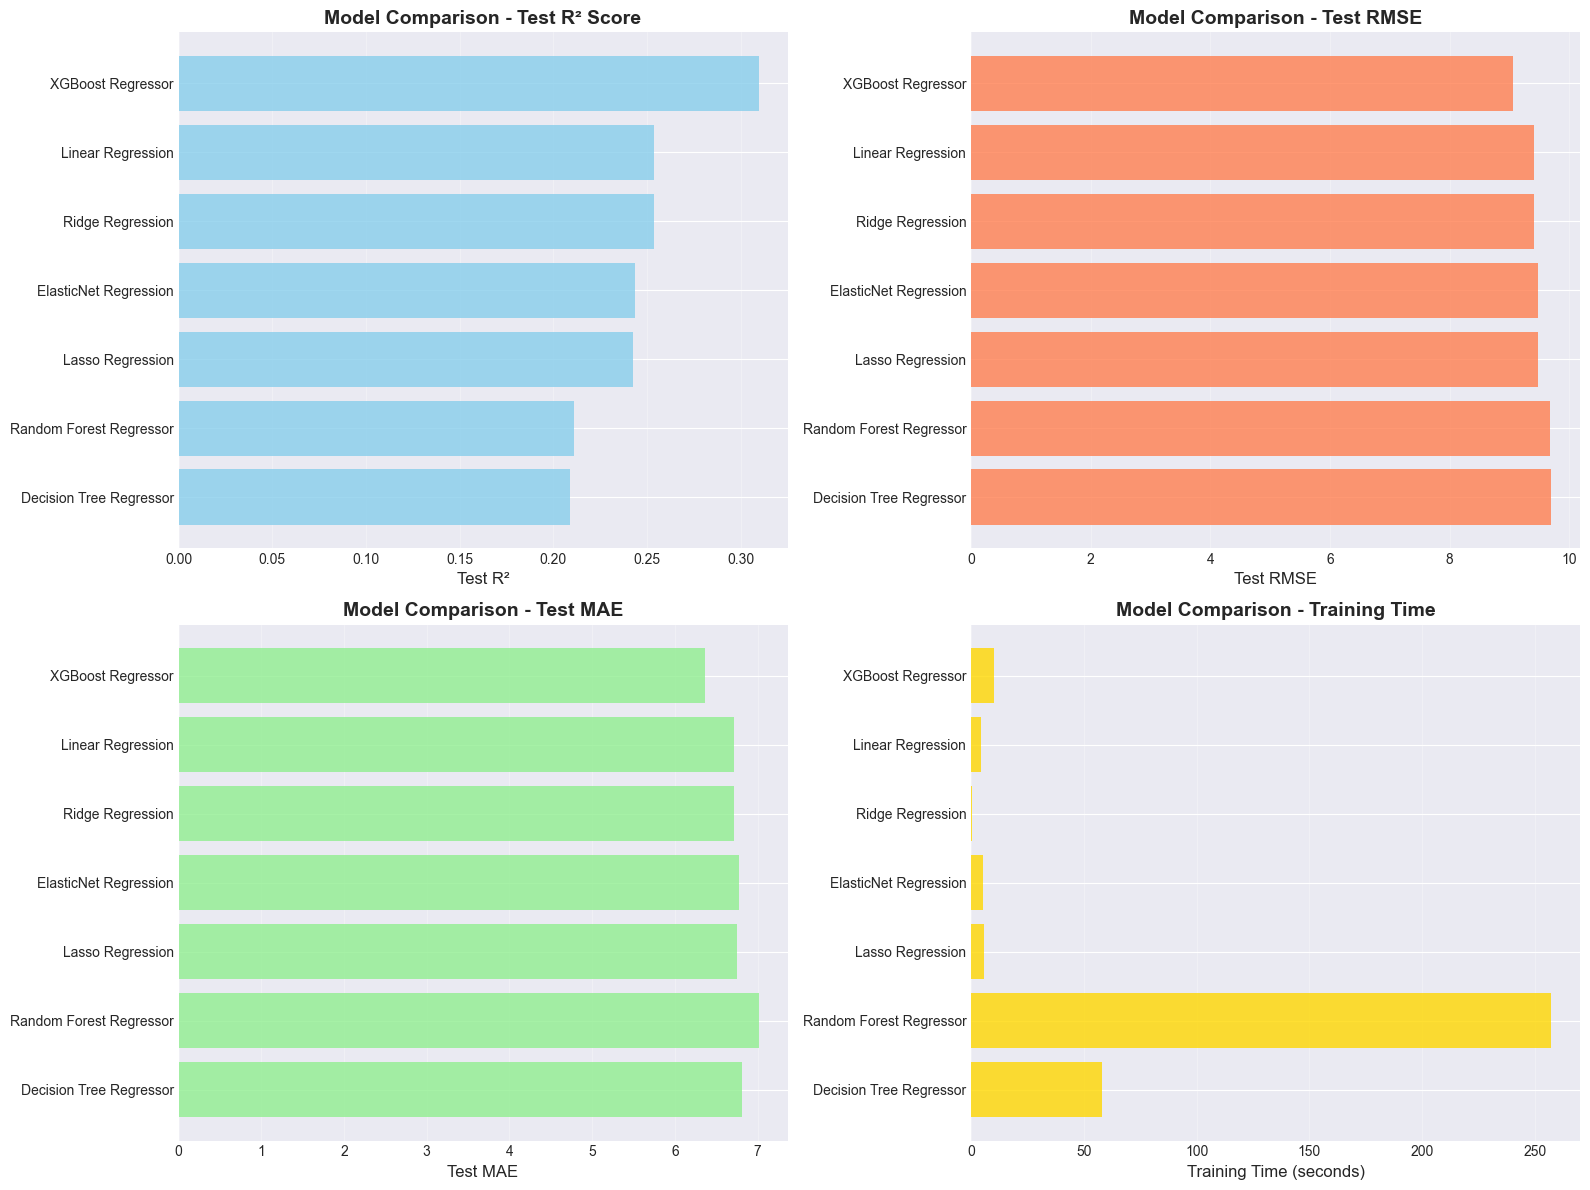


✓ Comparison chart saved as 'model_comparison.png'


In [17]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Test R² Comparison
axes[0, 0].barh(results_df['Model'], results_df['Test R²'], color='skyblue', alpha=0.8)
axes[0, 0].set_xlabel('Test R²', fontsize=12)
axes[0, 0].set_title('Model Comparison - Test R² Score', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3, axis='x')
axes[0, 0].invert_yaxis()

# 2. Test RMSE Comparison
axes[0, 1].barh(results_df['Model'], results_df['Test RMSE'], color='coral', alpha=0.8)
axes[0, 1].set_xlabel('Test RMSE', fontsize=12)
axes[0, 1].set_title('Model Comparison - Test RMSE', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='x')
axes[0, 1].invert_yaxis()

# 3. Test MAE Comparison
axes[1, 0].barh(results_df['Model'], results_df['Test MAE'], color='lightgreen', alpha=0.8)
axes[1, 0].set_xlabel('Test MAE', fontsize=12)
axes[1, 0].set_title('Model Comparison - Test MAE', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='x')
axes[1, 0].invert_yaxis()

# 4. Training Time Comparison
axes[1, 1].barh(results_df['Model'], results_df['Training Time (s)'], color='gold', alpha=0.8)
axes[1, 1].set_xlabel('Training Time (seconds)', fontsize=12)
axes[1, 1].set_title('Model Comparison - Training Time', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='x')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparison chart saved as 'model_comparison.png'")

## Save Models and Results

In [18]:
# Save all trained models (only those that were actually trained)
print("Saving trained models...\n")

# Build dictionary mapping model names to their results
model_mapping = [
    ('linear_regression', 'lr_results'),
    ('ridge_regression', 'ridge_results'),
    ('lasso_regression', 'lasso_results'),
    ('elasticnet_regression', 'elasticnet_results'),
    ('decision_tree', 'dt_results'),
    ('random_forest', 'rf_results'),
    ('gradient_boosting', 'gb_results'),
    ('xgboost', 'xgb_results'),
    ('svr', 'svr_results'),
    ('knn', 'knn_results')
]

models_to_save = {}

# Only add models that were actually trained
for model_name, result_var in model_mapping:
    try:
        result = eval(result_var)
        if result is not None:
            models_to_save[model_name] = result
    except NameError:
        # Variable doesn't exist, skip it
        pass

# Save each trained model
for model_name, results in models_to_save.items():
    with open(f'model_{model_name}.pkl', 'wb') as f:
        pickle.dump(results['model'], f)
    print(f"✓ Saved: model_{model_name}.pkl")

# Save results DataFrame
results_df.to_csv('model_results.csv', index=False)
print(f"\n✓ Saved: model_results.csv")

# Save all results including predictions
with open('all_model_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)
print(f"✓ Saved: all_model_results.pkl")

print("\n" + "="*80)
print("✅ MODEL TRAINING COMPLETE!")
print("="*80)
print(f"\n📁 Generated Files:")
print(f"   • {len(models_to_save)} model files (*.pkl)")
print(f"   • model_results.csv - Summary metrics")
print(f"   • all_model_results.pkl - Complete results with predictions")
print(f"   • model_comparison.png - Visualization")
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test R²: {best_test_r2:.4f}")
print(f"\n💡 Note: This model predicts song release year from audio features!")

Saving trained models...

✓ Saved: model_linear_regression.pkl
✓ Saved: model_ridge_regression.pkl
✓ Saved: model_lasso_regression.pkl
✓ Saved: model_elasticnet_regression.pkl
✓ Saved: model_decision_tree.pkl
✓ Saved: model_random_forest.pkl
✓ Saved: model_xgboost.pkl

✓ Saved: model_results.csv
✓ Saved: all_model_results.pkl

✅ MODEL TRAINING COMPLETE!

📁 Generated Files:
   • 7 model files (*.pkl)
   • model_results.csv - Summary metrics
   • all_model_results.pkl - Complete results with predictions
   • model_comparison.png - Visualization

🏆 Best Model: XGBoost Regressor
   Test R²: 0.3095

💡 Note: This model predicts song release year from audio features!
